### 0) Importing Required Modules:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from my_parsers import Parser
from my_plots import PiePlot, BarPlot

Loading BokehJS ...

### 1) XML Dataset Processing:

Fetching and parsing XML file to Pandas DF is executed with 'XmlParser' class, from file 'my_parsers.py'.

The class handles all the exceptions that can occur while downloading and parsing the XML file, and logs all the 
errors, warnings and information to console, enabling easy error tracking and code correction. Error handling and logging is showcased with 4 bad examples below.

In [2]:
# Example 1 - Non existing site
bad_url = 'http://bar.url.example.com'
xml = Parser.download_file(url=bad_url)

# Example 2 - Existing site, but bad path:
bad_url = 'https://data.cityofnewyork.us/api/views/BAD_POINT/rows.xml?accessType=DOWNLOAD'
xml = Parser.download_file(url=bad_url)

# Example 3 - Bad XML file (not an XML structure)
bad_xml = [1,2,3,4,5]
df = Parser.parse_xml_to_df(bad_xml)

# Example 4 - No XML file:
bad_xml = None
df = Parser.parse_xml_to_df(bad_xml)

ERROR: Connection error occurred - Please check your connection and provided URL!
ERROR: Download error 404 occurred - Please check the provided URL!
ERROR: Given XML file is corrupt - please check if downloaded properly!
ERROR: XML file not found - please check if downloaded properly!


With this class, the required XML class is processed directly to Pandas DF with just one code line.

In [3]:
### Dataframe Loading:
df = Parser().get_xml_df()

The fetched dataframe needs to be cleaned, as it contains some bad data. There are numerous poll datapoints that are made on 0 participants, and as such they need to be removed (without any participants no poll data can be obtained - all data inputted on 0 participants is invalid).

In [4]:
### Dataframe Processing:

# Rename column 'jurisdiction_name' to 'zip'
df = df.rename(columns={'jurisdiction_name':'zip'})

# Set the dataframe index to zipcode
# if 'jurisdiction_name' in df.columns:
#     df = df.set_index('jurisdiction_name')

# Drop all datapoints that don't have at least 1 participant (without participants no data can be gathered)
df = df[df['count_participants']>0] # 'count_participants' = 'count_gender_total' = 'count_ethnicity_total'

# Reset index:
df = df.reset_index(drop=True)

Prior to the breakdown analysis of male and female division by zip code, a basic data plot was displayed, to determine the distribution of data and select the appropriate breakdown approach. As was observed on the plot below, the data was very sparse, and highly concentrated just around few zip code zones. 

Due to that, the analysis of the dataset as a whole wouldn't have resulted in high information gain, and it was decided to group the data on given zip code ranges instead.

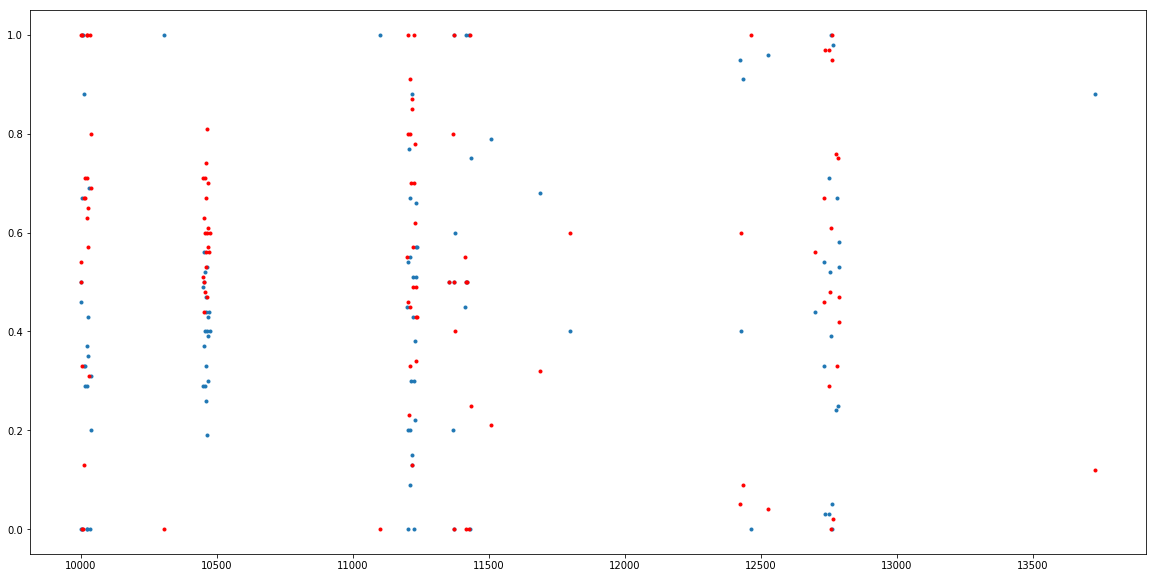

In [5]:
# Do a basic plot to get the feel of data distribution:
plt.figure(figsize=(20,10))
plt.plot(df.zip, df.percent_male, '.')
plt.plot(df.zip, df.percent_female, 'r.')
plt.show()

Optimal grouping range was determined by analyzing different ranges (250, 300,..., 750) and the grouping they achieved. 

It was determined that a zip code range of 500 (grouping zipcodes on 9750-10250, 10250-10750,...) gave the most natural data separation.

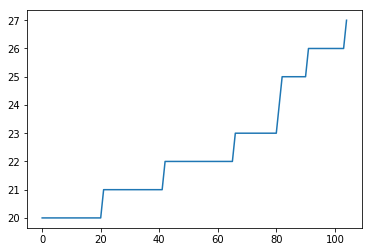

In [6]:
# for zip_range in range(250,751,50):
#     print('Range:',zip_range,'\t Groups:', len(round(df.zip/zip_range).value_counts()))
#     plt.plot(round(df.zip/zip_range))
#     plt.show()    

# It is determined that range of 500 (9750-10250, 10250-10750,...) gives the optimal data grouping
zip_range = 500
df['zip_group'] = (round(df.zip/zip_range)*zip_range).apply(round)

plt.plot(round(df.zip/zip_range))
plt.show()  

### A)  Breakdown of male and female division by zip code 

After grouping the data over proposed zip code groups, a violin plot was selected as the best visualization for showcasing the breakdown between men and women ratio over different zip code groups. To have comparable results over different datapoints, the sex percentage was analyzed (instead of sex count), as the 'count_gender_total' data provided in the dataset represented just the number of people participation in the poll, and not the population of given zip code area - it was not adequate for normalizing the data.

If was observed that first three zip code groups (codes from 10000-11250) had a quite higher ratio of women, the fourth group (codes 11250-11750) had a higher ratio of men, while the last two groups were more or less evened out.

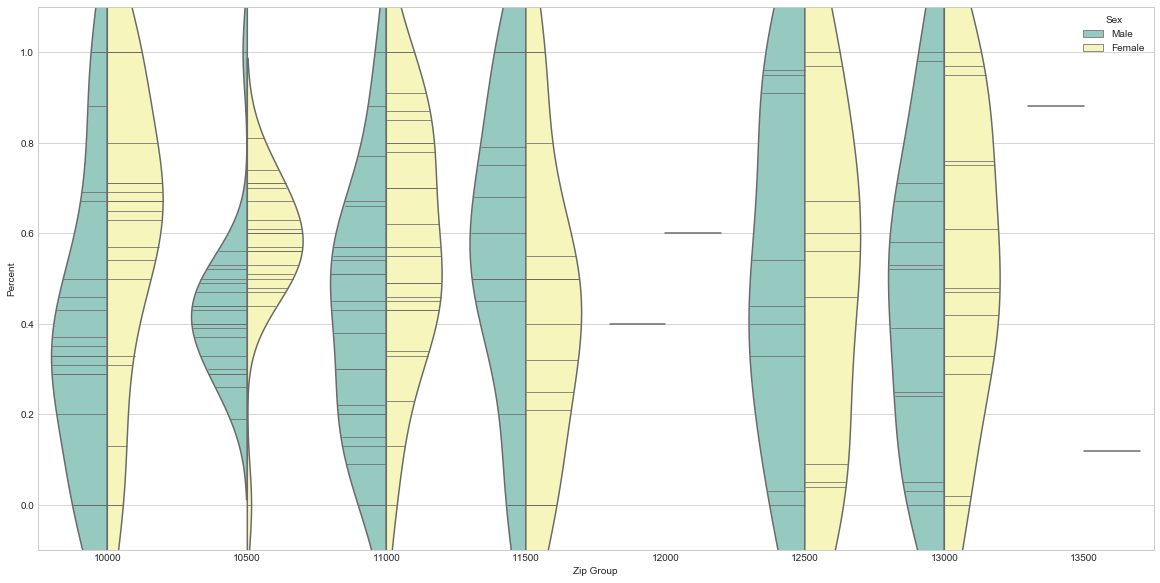

In [7]:
df1 = df[['zip_group','percent_male']].copy()
df2 = df[['zip_group','percent_female']].copy()
df1 = df1.rename(columns={'percent_male':'Percent', 'zip_group': 'Zip Group'})
df2 = df2.rename(columns={'percent_female':'Percent', 'zip_group': 'Zip Group'})
df1['Sex'] = 'Male'
df2['Sex'] = 'Female'
df_sex = pd.concat([df1, df2])
df_sex['Zip Group'] = df_sex['Zip Group'].apply(int)

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
ax = sns.violinplot(x="Zip Group", y="Percent", hue="Sex",
                    data=df_sex, palette="Set3", split=True,
                    scale="count", inner="stick")
plt.ylim((-0.1,1.1))
plt.show()

del df1, df2, df_sex

### B)  Breakdown of various demographics per zip code:

For clearer data representation, the data was grouped to previously proposed zip code ranges. Then the ethnicity percentage of certain ethnicity group for given zip code range was recalculated by dividing the sum of all ethnicity counts in that zip code range by the sum of all participants in that range.

A bubble plot was selected as the best tool for visualizing this breakdown, where the area of the bubble was proportional to the percentage of given ethnicity in given zip code group (bubble radius ~ sqrt(percentage)). However, the zip code groups around 12000 and 13500 should be taken with reserve, as they are based just on single datapoints (poll statistics from 1 zip code).

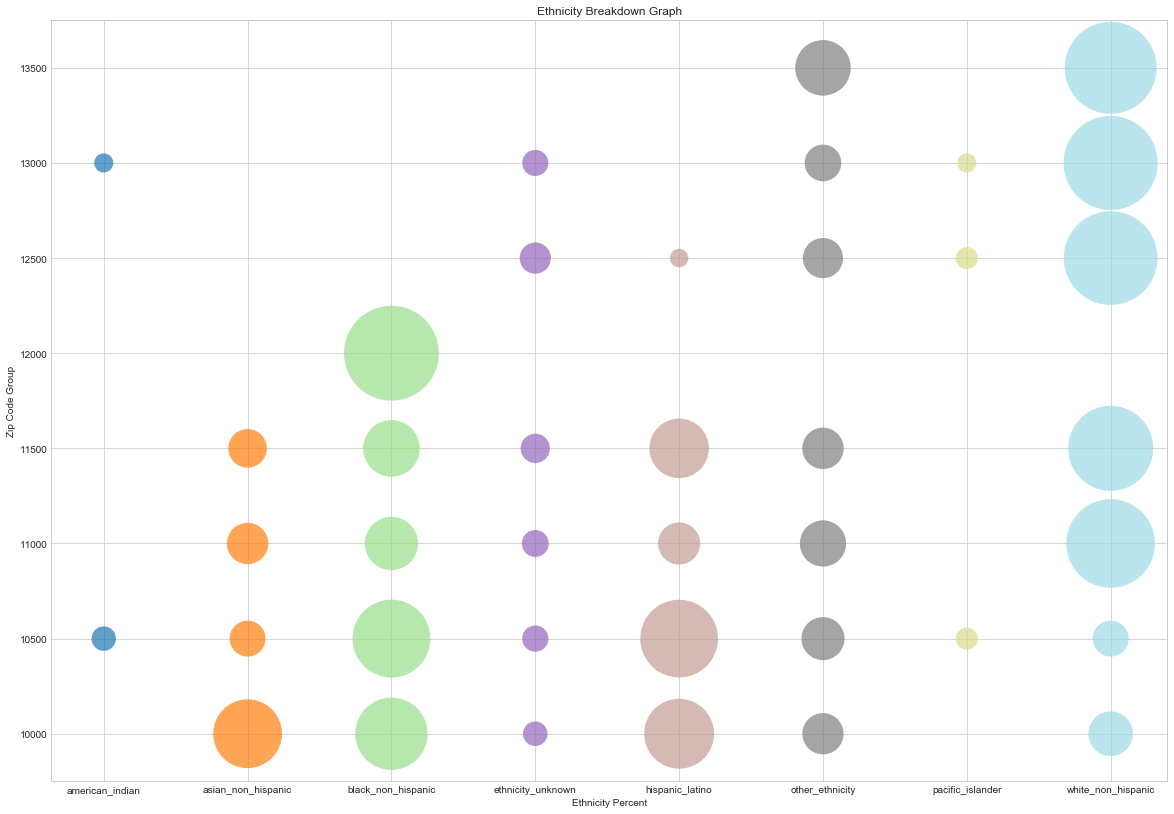

In [8]:
demographics = ['american_indian', 'asian_non_hispanic', 'black_non_hispanic', 'ethnicity_unknown', 
                'hispanic_latino', 'other_ethnicity', 'pacific_islander', 'white_non_hispanic']

df1 = df.groupby(['zip_group']).sum()

# Recalculate the percentage per zip group:
for col in demographics:
    df1['percent_'+col] = df1['count_'+col].div(df1['count_ethnicity_total'])
    
# Extract only percentage columns and rename them:
df1 = df1[['percent_'+x for x in demographics]]
df1.columns = demographics

# Create x, y and r arrays (for bubble plot)
x = [a for a in range(len(df1.columns)) for _ in range(len(df1))]
y = list(df1.index)*(len(df1.columns))
r = np.transpose(np.sqrt(df1.values)).reshape(-1,1)*9000

# Plot the figure:
fig, ax = plt.subplots(figsize=(20,14))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1:10] = demographics
plt.scatter(x=x, y=y, s=r, c=x, cmap="tab20", alpha=0.7, edgecolors="grey", linewidth=0)
 
# Add titles (main and on axis)
plt.xlabel("Ethnicity Percent")
plt.ylabel("Zip Code Group")
plt.title("Ethnicity Breakdown Graph")

plt.ylim((9750,13750))
ax.set_xticklabels(labels)
plt.show()

del df1, x, y, r

### 2) Loading the CSV file:

The CSV file parsing is again handled with the 'Parser' class from the 'my_parser.py' class.

In [9]:
df2 = Parser().get_csv_df()
df2 = df2.rename(columns={'ZIP Code': 'zip'})
# df2.head()

### 3) Merging two dataframes:

The two dataframes are joined with the pandas merge function (adding the additional information from the second dataframe to the first one, since the first dataframe is already cleared from invalid data).

In [10]:
df = df.merge(df2, how='left', on='zip')
# df[['zip','County Name', 'percent_female']].head()
del df2

### 4)  Breakdown of various demographics per county:

A brief overview of samples per county is carried out, to assess data validity.

In [11]:
df['County Name'].value_counts()

New York    23
Kings       23
Bronx       20
Sullivan    18
Queens      15
Ulster       6
Delaware     2
Greene       1
Suffolk      1
Richmond     1
Nassau       1
Name: County Name, dtype: int64

Again, data comparison between different counties was carried out in percent unit (as percents are relative units that can be compared directly, whereas counts are absolute units that need to be normalized to make them comparable between different counties).

By analyzing the data, it was concluded that the percent data is not completely valid (sometimes 'percent_ethnicity_total' is not equal to 100%), and therefore it was decided to recalculate the percent by normalizing the cumulative ethnicity counts in given county with total ethnicity count made in that county.

In [12]:
df1 = df.groupby(['County Name']).sum()

df1 = df1[['count_'+x for x in (demographics+['ethnicity_total'])]]
df1.columns = [x[6:] for x in df1.columns]

# Assess total number of paritcipants per county:
print(df1.ethnicity_total, '\n')

# Normalize the data with total ethnicity counts in given region:
for col in df1.columns:
    df1[col] = df1[col].div(df1.ethnicity_total)

# Drop the column with total counts:
df1 = df1.drop(columns=['ethnicity_total'])

# Check if calculated correctly:
print('Percent check:')
print(df1.values.sum(axis=1)==1.0)

County Name
Bronx        680.0
Delaware      99.0
Greene        21.0
Kings       1236.0
Nassau        28.0
New York     294.0
Queens        83.0
Richmond       1.0
Suffolk        5.0
Sullivan    1722.0
Ulster       368.0
Name: ethnicity_total, dtype: float64 

Percent check:
[ True  True  True  True  True  True  True  True  True  True  True]


For coding simplicity, data was immediately plotted with a interactive PiePlot function (imported from my_plots.py file). This function creates an interactive plot that gives the option of selecting the desired county, and also carrying out an analysis over several counties at the same time. But hovering over the pie graph, you can also get immediate information of exact population share for given county (or a combination of several counties).

By default, the plot displays the statistics for all counties combined, but by selecting the required counties on the left side, you can get the per county analysis.

In [13]:
PiePlot(df1)

By playing around with the pie plot, several observations were made:

    1) Bronx and New York have an above average share of hispanic and black ethnicities

    2) Sullivan, Ulster, Delaware, Greene and Kings have an above average share of white ethnicity

    3) Richmond is completely asian (this observation is made just on 1 participant -> so it should be disregarded)

    4) Suffolk is completely black (this observation is made just on 5 participants -> so it should be disregarded)

Other counties follow the average ethnicity distribution.

### 5) Developmental Disabilities Services:

To review the access to disability services per county, the data was first extracted from the provided JSON.

For coding simplicity, this functionality was directly embedded in the Parser class (from 'my_parser.py' file). First, a column name and descriptions were extracted from the JSON's meta information, to define the required columns for data extraction (county, zip code and different services). Then, the actual data was extracted from the JSON's data object, and parsed into a Pandas dataframe.

In [14]:
df2 = Parser().get_json_df()

As certain zip areas had several data entries - representing different offices providing developmental disability services, the data was aggregated on zip code level, where certain service was marked as provided, if at least one office in that zip code offered that service (assuming that one office was enough to cover one zip area).

In [15]:
# Aggregate different offices providing services in same zipcode area:
df2 = df2.groupby(['County', 'Zip Code']).sum()

# Mark the service as provided if at least one office in that zip area provides it:
df2 = (df2>0).astype(int)

# Save service names:
services = [str(x)for x in df2.columns]

df2.head(10)

Intermediate Care Facilities (ICFs)  \
County   Zip Code                                        
ALBANY   12047                                       0   
         12054                                       0   
         12202                                       0   
         12203                                       1   
         12204                                       0   
         12205                                       1   
         12208                                       0   
ALLEGANY 14895                                       0   
BRONX    10451                                       0   
         10452                                       0   

                   Individual Residential Alternative (IRA)  Family Care  \
County   Zip Code                                                          
ALBANY   12047                                            0            0   
         12054                                            0            0   
         12202                                            0            0   
         12203                                            1            0   
         12204                                            0            0   
         12205                                            1            0   
         12208                                            1            0   
ALLEGANY 14895                                            1            1   
BRONX    10451                                            0            0   
         10452                                            1            0   

                   Self-Direction Services  \
County   Zip Code                            
ALBANY   12047                           0   
         12054                           0   
         12202                           0   
         12203                           0   
         12204                           0   
         12205                           1   
         12208                           0   
ALLEGANY 14895                           1   
BRONX    10451                           0   
         10452                           0   

                   Individual Support Services (ISSs)  Day Training  \
County   Zip Code                                                     
ALBANY   12047                                      0             0   
         12054                                      0             0   
         12202                                      0             0   
         12203                                      1             0   
         12204                                      0             0   
         12205                                      1             0   
         12208                                      1             0   
ALLEGANY 14895                                      1             0   
BRONX    10451                                      0             0   
         10452                                      0             0   

                   Day Treatment  Senior/Geriatric Services  Day Habilitation  \
County   Zip Code                                                               
ALBANY   12047                 0                          0                 1   
         12054                 0                          0                 0   
         12202                 0                          0                 0   
         12203                 0                          0                 1   
         12204                 0                          0                 0   
         12205                 0                          0                 0   
         12208                 0                          0                 1   
ALLEGANY 14895                 0                          0                 1   
BRONX    10451                 0                          0                 0   
         10452                 0                          0                 1   

                   Work Shop  

After that, the data was aggregated on a county level, where a certain service availability was expressed in percent’s, based on how many zip areas of that county offered said service (e.g. if 7 out of 10 zip areas within one county offered said service, the availability would be marked as 70%, etc.).

In [16]:
# Aggreagte the data on county level, and calculate county mean:
df2 = df2.groupby(['County']).mean()

# Convert data to percent:
df2 = df2*100

# df2.head()

Then a selection of required counties (obtained from part 4) was made.

In [17]:
counties_of_interest = ['BRONX', 'NEW YORK', 'SULLIVAN', 'ULSTER', 'DELAWARE', 'KINGS', 'RICHMOND', 'SUFFOLK']
df3 = df2.loc[counties_of_interest]

# df3.head(10)

Finally, a stack bar graph was plotted to showcase the service availability over different counties, offering an interactive hover function (displaying exact availability of certain service at given county). Again, the availability of certain service was defined as the ratio between zip areas offering that service divided by the total number of zip areas in given county.

For coding simplicity, the graph was again framed within a function 'BarPlot' (imported form 'my_plots.py'), and realized just with one code line.

In [18]:
BarPlot(df3)

By observing the obtained graph, it was determined that Ulster had the highest cumulative service availability of the selected, however, it was still missing some services, and Richmond, while having a somewhat lower over availability, had a bigger variety of services. Bronx, Delaware and Suffolk had an extremely low service availability, with Bronx and Delaware also having a quite low variety of services. New York was slightly better, but still on the low side.

To compare the results against country average, all the counties were analyzed on the graph below. It was observed that Ulster had an above average availability (country-wide), and Richmond was just slightly above average, while the other counties analyzed above were in the low ranking (country-wide).

In [19]:
BarPlot(df2)